<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Quantum Computing Research**

###### *IonQ with Cirq*

In [ ]:
!pip install cirq-ionq -q
import cirq_ionq # https://docs.ionq.com/sdks/cirq
import cirq      # https://quantumai.google/cirq/hardware/ionq/circuits
import json
import pickle
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import files
from collections import Counter
import matplotlib.pyplot as plt
import cirq_ionq.ionq_exceptions as ionq_exceptions
print(f"Cirq version: {cirq.__version__}")
print(f"Cirq-IonQ version: {cirq_ionq.__version__}")

Cirq version: 1.6.1
Cirq-IonQ version: 1.6.1


In [ ]:
# Connect to IonQ Service and Secret Manager for Token
from google.colab import userdata
api_token = userdata.get('ionq-quantum')
service = cirq_ionq.Service(api_key=api_token)

In [ ]:
# Check Available Backends (Simulators and QPUs) --> https://cloud.ionq.com/backends/qpus
headers = {"Authorization": f"apiKey {'ionq-quantum'}"}
r = requests.get("https://api.ionq.co/v0.3/backends", headers=headers)
if r.status_code == 200:
    for i, b in enumerate(r.json(), 1):
        qt = b.get('average_queue_time', 0)
        print(f"\n{i}. {b['backend'].upper()}\n └── Type: {'QPU' if 'qpu' in b['backend'] else 'Simulator'}\n └── Status: {b['status'].upper()}\n └── Qubits: {b['qubits']}\n └── Average Queue Time: {f'{qt/3600:.1f} hours' if qt > 3600 else f'{qt/60:.1f} minutes' if qt > 60 else f'{qt} seconds'}" + (''.join([f"\n └── Available Noise Models: {', '.join(b['noise_models'])}" if 'noise_models' in b else "", f"\n └── Characterization: Available" if 'characterization_url' in b else "", f"\n └── DEGRADED SERVICE" if b.get('degraded', False) else ""])))
else: print(f"Backend check failed: {r.status_code}\nError details: {r.text}")


1. QPU.HARMONY
 └── Type: QPU
 └── Status: RETIRED
 └── Qubits: 11
 └── Average Queue Time: 0 seconds

2. QPU.ARIA-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 25
 └── Average Queue Time: 3981.8 hours
 └── Characterization: Available

3. QPU.ARIA-2
 └── Type: QPU
 └── Status: RETIRED
 └── Qubits: 25
 └── Average Queue Time: 0 seconds
 └── Characterization: Available

4. SIMULATOR
 └── Type: Simulator
 └── Status: AVAILABLE
 └── Qubits: 29
 └── Average Queue Time: 0 seconds
 └── Available Noise Models: aria-1, harmony, ideal

5. QPU.FORTE-1
 └── Type: QPU
 └── Status: AVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 50198.5 hours
 └── Characterization: Available

6. QPU.FORTE-ENTERPRISE-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 11979.8 hours
 └── Characterization: Available


In [ ]:
# https://quantumai.google/cirq/hardware/ionq/calibrations
calibration = service.get_current_calibration()
print(calibration.fidelities())
print(calibration.timings())

**Use Case: Two-Qubit Entangled [Bell State](https://en.wikipedia.org/wiki/Bell_state) Preparation $|\Phi^+\rangle$**

* Start with two qubits, $q_0$ and $q_1$, both initialized to the $|0\rangle$ state, creating the state **$|00\rangle$**.

* Hadamard gate puts $q_0$ into a **superposition**, meaning it is equally likely to be measured as $|0\rangle$ or $|1\rangle$.
  * Hadamard on the first qubit $q_0$:  $|00\rangle \xrightarrow{H \otimes I} \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes |0\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$
  * The state becomes $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$

* CNOT gate for **Entanglement** (using $q_0$ as the control and $q_1$ as the target): CNOT flips $q_1$ only if $q_0$ is $|1\rangle$  
    * If $q_0$ is $|0\rangle$, $q_1$ stays $|0\rangle$ (path $|00\rangle \to |00\rangle$).
    * If $q_0$ is $|1\rangle$, $q_1$ flips from $|0\rangle$ to $|1\rangle$ (path $|10\rangle \to |11\rangle$).
    * $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle) \xrightarrow{\text{CNOT}} \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$
    * The state becomes $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$

This final state, $|\Phi^+\rangle$, is a maximally *entangled Bell state* $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ because measuring $q_0$ instantly determines $q_1$:with each outcome ('00' or '11') occurring with a $\mathbf{50\%}$ probability.
* The amplitude for $|00\rangle$ is $1/\sqrt{2}$. The probability $P('00') = |1/\sqrt{2}|^2 = 0.5$
* The amplitude for $|11\rangle$ is $1/\sqrt{2}$. The probability $P('11') = |1/\sqrt{2}|^2 = 0.5$

In [ ]:
# Define Circuit - Two-Qubit Bell state Preparation |Φ+⟩
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='x'))
print(circuit)

0: ───H───@───M('x')───
          │   │
1: ───────X───M────────


In [ ]:
# Theoretical Calculation (Exact probability distribution based on state vector simulation)
def calculate_exact_noiseless_probabilities(circuit: cirq.Circuit) -> dict:

    # 1. Circuit Preparation and Measurement Removal
    """
    The purpose of a state vector simulation is to find the final quantum state before
    the measurement operation collapses it. Removing the terminal cirq.measure gate ensures
    the simulator provides the final superposition state |Φ⁺⟩
    """
    circuit_without_measurements = cirq.drop_terminal_measurements(circuit)

    # 2. State Vector Simulation
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit_without_measurements)
    final_state_vector = result.final_state_vector

    exact_counts = {}

    # 3. Probability and Count Calculation
    for i, amplitude in enumerate(final_state_vector):
        probability = np.abs(amplitude)**2
        count = round(probability * 100)  # Convert to counts for number of shots ('repetitions=')

    # 4. Result Mapping
        if count > 0:
            exact_counts[i] = count  # Use integer key like {0: 50, 3: 50}
    return exact_counts
theoretical_prediction = calculate_exact_noiseless_probabilities(circuit)

print("--- Theoretical Count Distribution ---")
print(f"Counter({theoretical_prediction})")
theoretical_counter = Counter(theoretical_prediction) # mock counter object to match format

# Store results for later comparison
with open('theoretical_result.pkl', 'wb') as f:
    pickle.dump(theoretical_counter, f)

--- Theoretical Count Distribution ---
Counter({0: 50, 3: 50})


In [ ]:
# Noiseless simulation
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noiseless Cirq Simulation")
print(result.histogram(key='x'))
print(result)
with open('noiseless_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({3: 53, 0: 47})
x=1101101100010001011111001101111100111001101101101110001000110010100101000000011111101001100110100110, 1101101100010001011111001101111100111001101101101110001000110010100101000000011111101001100110100110


In [ ]:
# Noisy simulation
# https://docs.ionq.com/guides/simulation-with-noise-models
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noisy Cirq Simulation",
    extra_query_params={"noise": {"model": "forte-1"}})
print(result.histogram(key='x'))
print(result)
with open('noisy_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 56, 3: 43, 2: 1})
x=0100101101100001110001000100001001101010011000010011010001101101100100100001010110110101111010011000, 0100101101100001110001000100001001101010011000010011010001101101100100100001010110110101111000011000


In [ ]:
# Quantum Simulation
# (https://docs.ionq.com/guides/qpu-submission-checklist)
job = service.create_job(
    circuit=circuit,
    target="qpu.forte-1", # forte-enterprise-1, aria-1
    repetitions=100,
    name="QPU Cirq Simulation")
print(job.job_id())
print(job.status())

019a7d6c-a0fb-779b-9340-8795a9a2f1c0
submitted


In [ ]:
# See job queue: https://cloud.ionq.com/jobs
job_id = "019a7d6c-a0fb-779b-9340-8795a9a2f1c0"
print(job.status())

completed


In [ ]:
# Retrieve a job
#job_id = "019a7d6c-a0fb-779b-9340-8795a9a2f1c0"
#job = service.get_job(job_id)

# Get the first result from the list
results_list = job.results()
result = results_list[0].to_cirq_result()  # Access first element
print(result.histogram(key='x'))
# Save results into file
with open('quantum_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 55, 3: 43, 1: 1, 2: 1})



RESULTS:
 State Binary  Theory  Noiseless  Noisy  Quantum
     0     00      50         47     56       55
     1     01       0          0      0        1
     2     10       0          0      1        1
     3     11      50         53     43       43



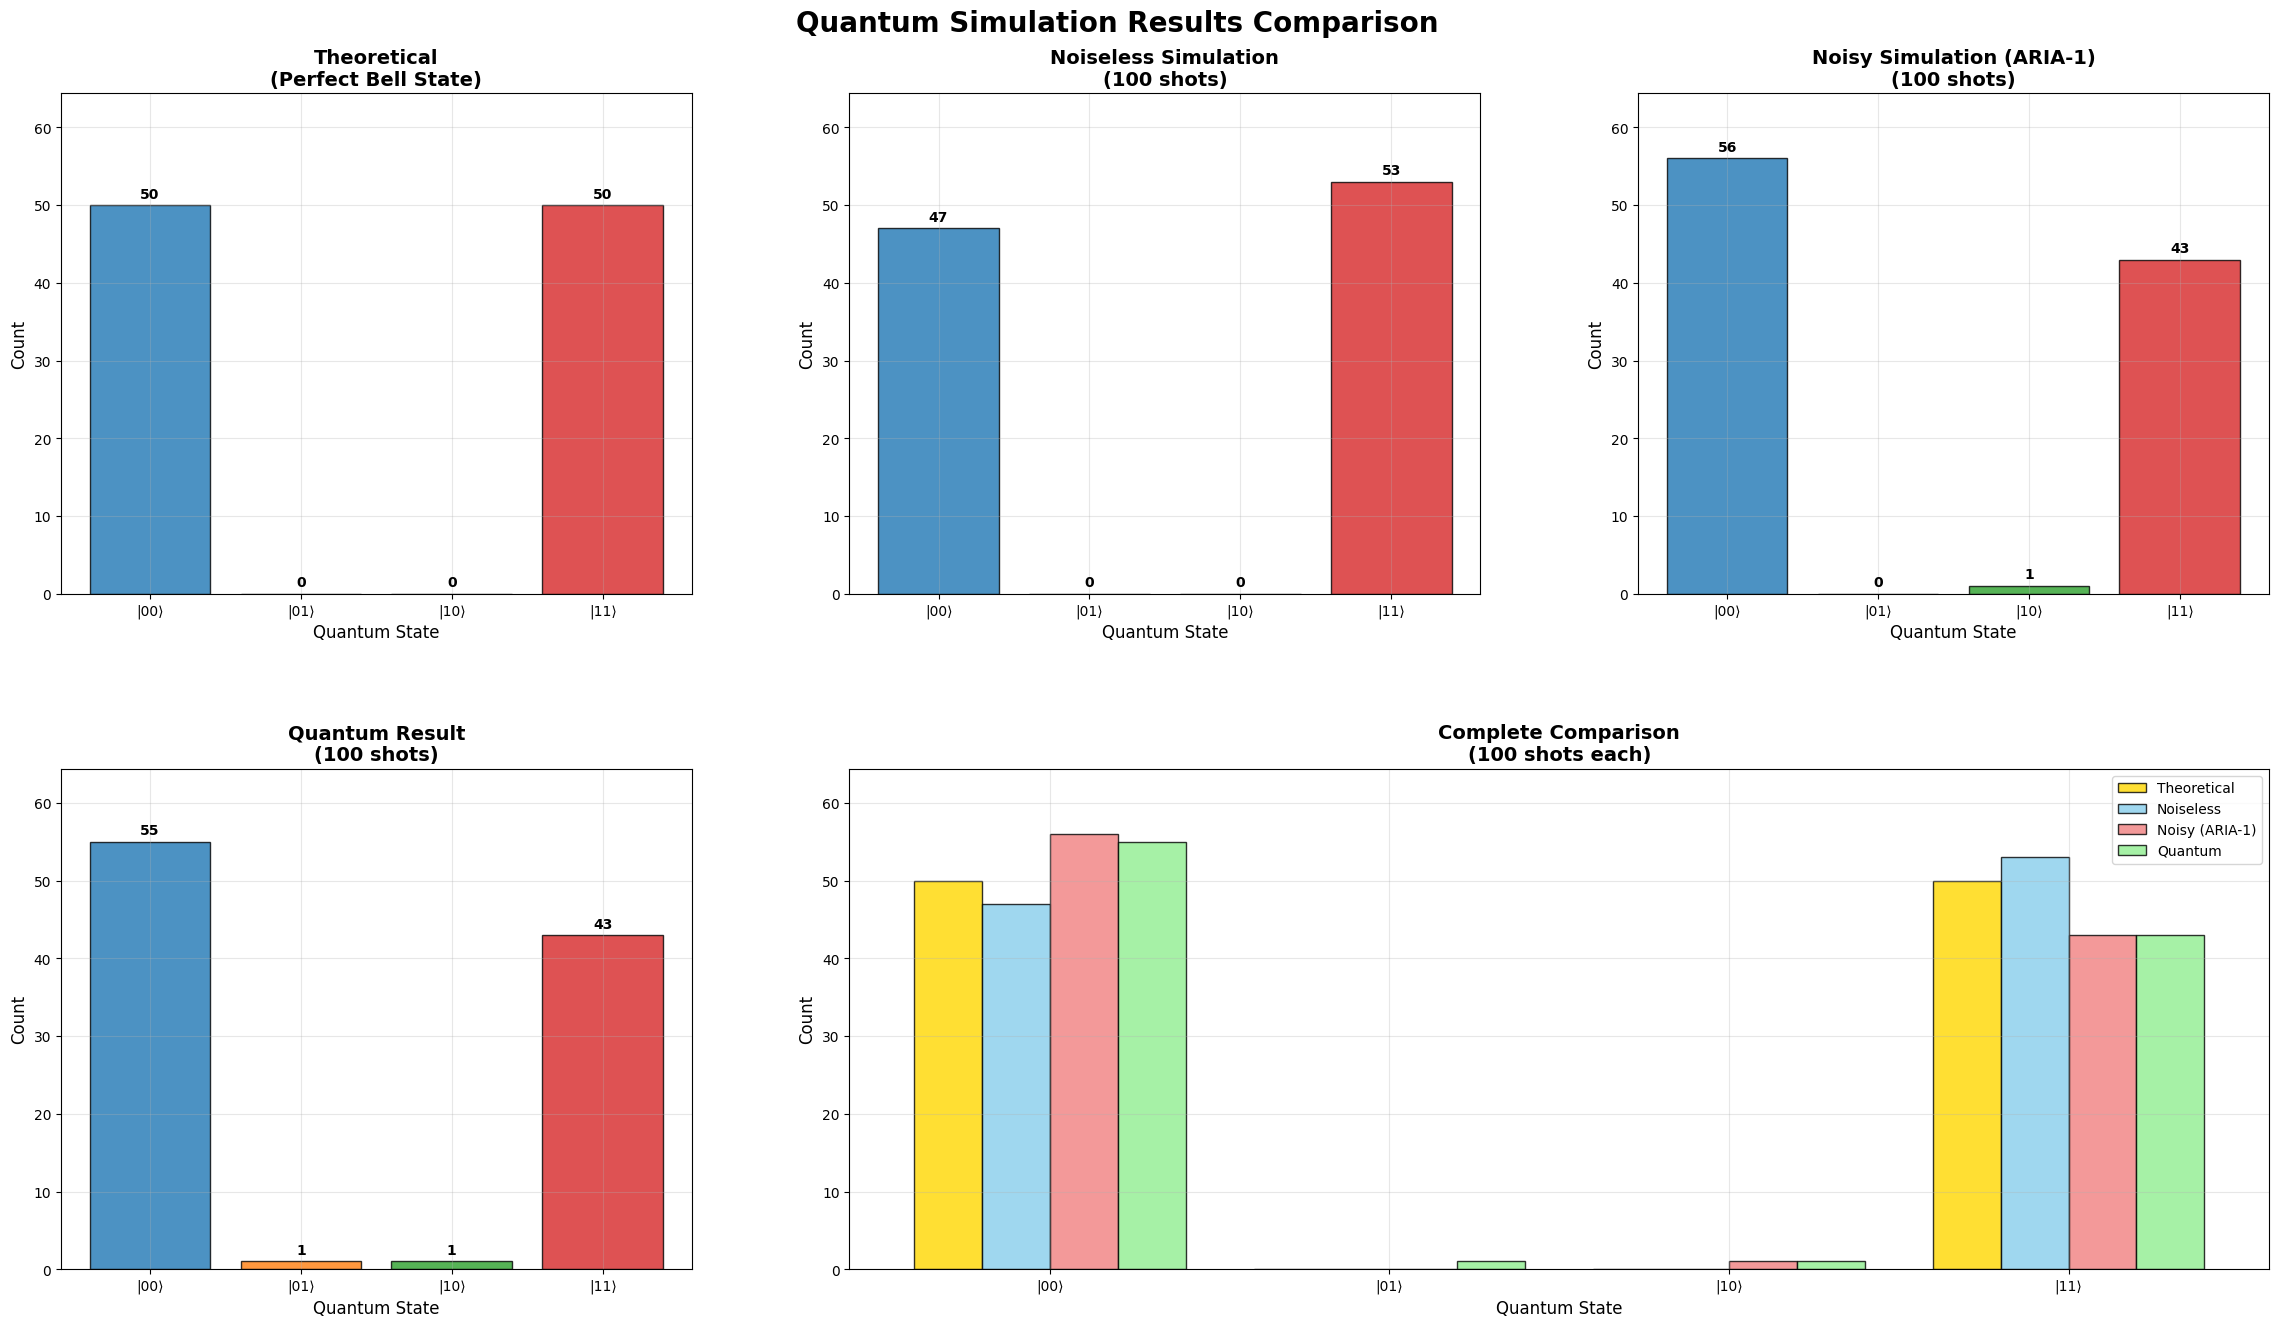

In [ ]:
# @title Comparison of Results
data = {}
for name in ['noiseless', 'noisy', 'theoretical', 'quantum']:
    with open(f'{name}_result.pkl', 'rb') as f:
        result = pickle.load(f)
        data[name] = result.histogram(key='x') if hasattr(result, 'histogram') else result

# Create comparison DataFrame
states = range(4)
comparison_df = pd.DataFrame({
    'State': states,
    'Binary': [format(s, '02b') for s in states],
    'Theory': [data['theoretical'].get(s, 0) for s in states],
    'Noiseless': [data['noiseless'].get(s, 0) for s in states],
    'Noisy': [data['noisy'].get(s, 0) for s in states],
    'Quantum': [data['quantum'].get(s, 0) for s in states]
})

print("\nRESULTS:\n" + "="*50)
print(comparison_df.to_string(index=False))
print("="*50 + "\n")

# Plotting
fig = plt.figure(figsize=(24, 14))
fig.suptitle('Quantum Simulation Results Comparison', fontsize=20, fontweight='bold', y=0.98)

state_labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plot_configs = [
    (1, 'Theory', 'Theoretical\n(Perfect Bell State)'),
    (2, 'Noiseless', 'Noiseless Simulation\n(100 shots)'),
    (3, 'Noisy', 'Noisy Simulation (ARIA-1)\n(100 shots)'),
    (4, 'Quantum', 'Quantum Result\n(100 shots)')
]

max_count = comparison_df[['Theory', 'Noiseless', 'Noisy', 'Quantum']].max().max()

# Individual plots
for idx, col, title in plot_configs:
    ax = plt.subplot(2, 3, idx)
    bars = ax.bar(state_labels, comparison_df[col], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('Quantum State', fontsize=12)
    ax.set_ylim(0, max_count * 1.15)
    ax.grid(True, alpha=0.3)

    # Add count labels
    for bar, count in zip(bars, comparison_df[col]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_count*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Comparison plot
ax5 = plt.subplot(2, 3, (5, 6))
x = np.arange(4)
width = 0.2
plot_data = [
    ('Theory', 'Theoretical', 'gold'),
    ('Noiseless', 'Noiseless', 'skyblue'),
    ('Noisy', 'Noisy (ARIA-1)', 'lightcoral'),
    ('Quantum', 'Quantum', 'lightgreen')
]

for i, (col, label, color) in enumerate(plot_data):
    ax5.bar(x + (i-1.5)*width, comparison_df[col], width, label=label,
            color=color, alpha=0.8, edgecolor='black')

ax5.set_title('Complete Comparison\n(100 shots each)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Count', fontsize=12)
ax5.set_xlabel('Quantum State', fontsize=12)
ax5.set_xticks(x)
ax5.set_xticklabels(state_labels)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0, max_count * 1.15)

plt.subplots_adjust(left=0.06, bottom=0.08, right=0.98, top=0.92, wspace=0.25, hspace=0.35)
plt.show()

###### *IBM with Qiskit*

In [ ]:
!pip install qiskit qiskit-ibm-runtime qiskit[visualization] -q
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [ ]:
## 1. Connect to IBM Quantum
api_token = userdata.get('ibm-quantum')

# Pass both the token and the channel
service = QiskitRuntimeService(channel='ibm_quantum_platform', token=api_token)

backend = service.least_busy(simulator=False, operational=True)
print(f"Selected backend: {backend.name}")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-24 14:58:30,762: Default instance not set. Searching all available instances.


Selected backend: ibm_brussels



Ideal Circuit Diagram:


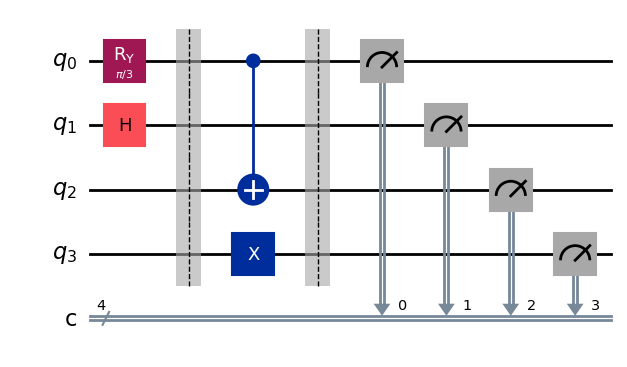

In [ ]:
# 2. Create the Quantum Circuit with Asymmetric State Evolution (with Unequal Superposition)
qc = QuantumCircuit(4, 4)
qc.ry(np.pi / 3, 0) # Replace H(0) with Ry(pi/3, 0) to create a 75%/25% split
qc.h(1)             # Keep the H on q1 for a 50/50 split
qc.barrier()
qc.cx(0, 2)
qc.x(3)
qc.barrier()
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
print("\nIdeal Circuit Diagram:")
display(qc.draw("mpl"))


Transpiled Circuit for ibm_brussels:


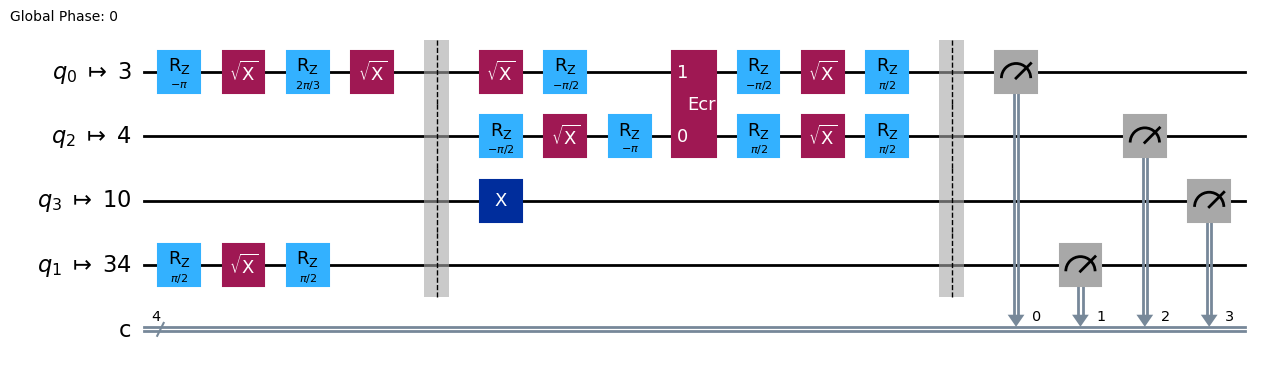

In [ ]:
# 3. Transpile circuit for backend (translates ideal circuit into one the hardware can run)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
print(f"\nTranspiled Circuit for {backend.name}:")
display(isa_circuit.draw("mpl"))

In [ ]:
# 4. Run job on IBM quantum computer
sampler = Sampler(mode=backend)
shots = 1024
print(f"\nSubmitting job to {backend.name}...")
job = sampler.run(pubs=[(isa_circuit,)], shots=shots) # Run transpiled 'isa_circuit', not original 'qc'
print(f"Job submitted successfully! Job ID: {job.job_id()}")


Submitting job to ibm_brussels...
Job submitted successfully! Job ID: d3615tl7ibtc73dlifgg


In [ ]:
job.status()

'DONE'

In [ ]:
job.metrics()

{'timestamps': {'created': '2025-09-18T14:11:02.899474Z',
  'finished': '2025-09-18T14:15:53.524337Z',
  'running': '2025-09-18T14:15:36.902052Z'},
 'bss': {'seconds': 3},
 'usage': {'quantum_seconds': 3, 'seconds': 3},
 'qiskit_version': 'qiskit_ibm_runtime-0.41.1,qiskit-2.1.2*',
 'caller': 'qiskit_ibm_runtime~sampler.py'}

In [ ]:
job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-09-18 14:15:51', stop='2025-09-18 14:15:53', size=1024>)])}, 'version': 2})


Measurement Results (Counts):
{'1000': 390, '1010': 350, '1101': 121, '1110': 4, '1111': 141, '0010': 4, '0111': 2, '1001': 1, '1100': 5, '1011': 2, '0101': 1, '0000': 3}

Result Histogram:


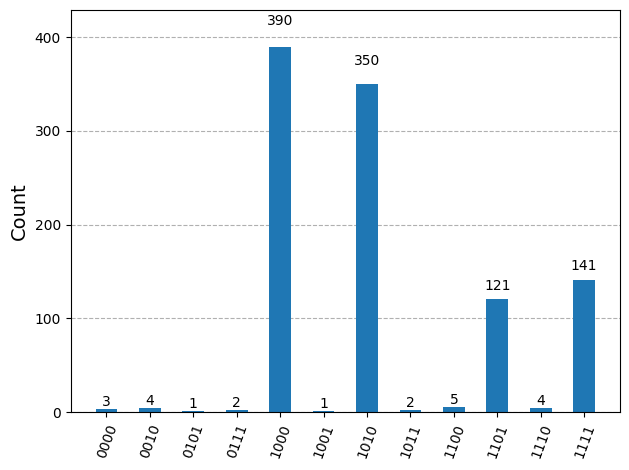

In [ ]:
# 5. Get and display results
result = job.result()
counts = result[0].data.c.get_counts()
print("\nMeasurement Results (Counts):")
print(counts)
plot_histogram(counts)


Local Simulation results (counts) with 1024 shots:
{'1101': 118, '1111': 131, '1000': 388, '1010': 387}

Local Simulation Probabilities:
  |1000>: 0.379 (388/1024)
  |1010>: 0.378 (387/1024)
  |1101>: 0.115 (118/1024)
  |1111>: 0.128 (131/1024)

Local Simulation Histogram:


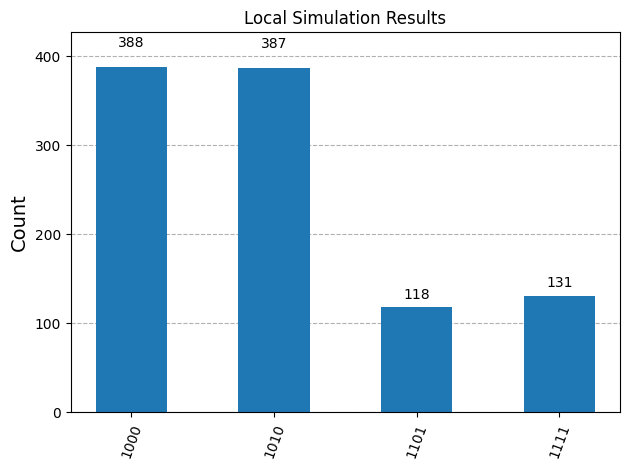

In [ ]:
# Appendix: Run local simulation
from qiskit.primitives import StatevectorSampler as LocalSampler
from qiskit.visualization import plot_histogram

local_sampler = LocalSampler() # Create local sampler
local_shots = 1024
local_job = local_sampler.run(pubs=[(qc,)], shots=local_shots) # Run circuit
local_result = local_job.result()
local_counts = local_result[0].data.c.get_counts() # Extract counts from result
print(f"\nLocal Simulation results (counts) with {local_shots} shots:")
print(local_counts)
print("\nProbabilities:")
for bitstring, count in sorted(local_counts.items()):
    probability = count / local_shots
    print(f"  |{bitstring}>: {probability:.3f} ({count}/{local_shots})")

display(plot_histogram(local_counts, title="Local Simulation Results"))

Devices: https://eu-de.quantum.cloud.ibm.com/computers

Topology: https://eu-de.quantum.cloud.ibm.com/docs/de/guides/qpu-information

Jobs: https://eu-de.quantum.cloud.ibm.com/workloads

Cost: https://cloud.ibm.com/billing

Tutorials: https://eu-de.quantum.cloud.ibm.com/docs/de/tutorials

###### *Quantum Chemistry*

In [ ]:
!pip install pyscf geometric periodictable qutip cirq openfermion openfermionpyscf -q
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, hessian, dft, tddft, mp, cc
from pyscf.geomopt.geometric_solver import optimize
import scipy.optimize
import itertools
import cirq
from openfermion import MolecularData, FermionOperator
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf

*Select Molecule*

In [ ]:
# Hydrogen (H₂)
mol = gto.Mole()
mol.atom = '''
    H  0.00 0.00  0.00
    H  0.00 0.00  0.74
'''
molecule = 'Hydrogen (H₂)'

In [ ]:
# Oxygen (O₂)
mol = gto.Mole()
mol.atom = '''
    O  0.00 0.00  0.00
    O  0.00 0.00  1.21
'''
molecule = 'Oxygen (O₂)'

In [ ]:
# Water (H₂O)
mol = gto.Mole()
mol.atom = '''
    O  0.000000  0.000000  0.000000
    H  0.000000  0.757000  0.586000
    H  0.000000 -0.757000  0.586000
'''
molecule = 'Water (H₂O)'

In [ ]:
# Build molecule (with gto.M() function)
mol.atom = mol.atom
mol.basis = 'sto-3g'  # sto-3g, cc-pvdz, 6-31G, for transition metals: 'def2-svp', 'def2-tzvp', 'lanl2dz'
mol.ecp = False       # Set to = mol.basis for Femoco
mol.symmetry = True
mol.spin = False
mol.charge = False
#mol.verbose = 4
mol.build()

In [ ]:
# Details about the molecule
def print_molecule_info(mol):
    print("="*50)
    print(f"Molecule Summary for {molecule}")
    print("="*50)
    print(f"Atoms: {mol.natm}")
    print(f"Electrons: {mol.nelectron}")
    print(f" Alpha electrons: {mol.nelec[0]}")
    print(f" Beta electrons: {mol.nelec[1]}")
    print(f"Basis: {mol.basis}")
    print(f"Basis functions: {mol.nao}")
    print(f"Charge: {mol.charge}")
    print(f"Spin (2S): {mol.spin}")
    print(f"Multiplicity (2S+1): {mol.spin + 1}")
    print(f"Nuclear repulsion energy: {mol.energy_nuc():.6f} Hartree")
    # Point group symmetry
    print(f"Top group: {mol.topgroup}")
    print(f"Group name: {mol.groupname}")
    print("\nAtom Coordinates (Angstrom):")
    for ia in range(mol.natm):
        symb = mol.atom_symbol(ia)
        coord = mol.atom_coord(ia) * 0.52917721067
        print(f"  {symb:2s}  {coord[0]:10.6f}  {coord[1]:10.6f}  {coord[2]:10.6f}")
    print("="*50)
print_molecule_info(mol)

Molecule Summary for Hydrogen (H₂)
Atoms: 2
Electrons: 2
 Alpha electrons: 1
 Beta electrons: 1
Basis: sto-3g
Basis functions: 2
Charge: False
Spin (2S): False
Multiplicity (2S+1): 1
Nuclear repulsion energy: 0.715104 Hartree
Top group: Dooh
Group name: Dooh

Atom Coordinates (Angstrom):
  H     0.000000    0.000000    0.000000
  H     0.000000    0.000000    0.740000


**Quantum Ground State Calculation with UCCSD**

In [ ]:
# Choose Ansatz: 'UCCSD' or 'HEA' (Hardware Efficient, np.zeros + 0.01 initialization)
ANSATZ_TYPE = 'UCCSD'

In [ ]:
# Dynamic Bridge & Helpers

def get_hamiltonian_from_mole(mol):
    """Bridging function: PySCF Mol -> OpenFermion QubitOperator"""
    n_atoms = mol.natm
    basis = mol.basis
    multiplicity = mol.spin + 1
    charge = mol.charge

    print(f"-> Bridging Molecule: {n_atoms} atoms, Basis: {basis}, Multiplicity: {multiplicity}")

    symbols = [mol.atom_symbol(i) for i in range(n_atoms)]
    coords = mol.atom_coords(unit='Angstrom')
    geometry = [[symbols[i], list(coords[i])] for i in range(n_atoms)]

    molecule_data = MolecularData(geometry, basis, multiplicity, charge)
    molecule_data = run_pyscf(molecule_data, run_scf=True)

    mh = molecule_data.get_molecular_hamiltonian()
    fh = get_fermion_operator(mh)
    qubit_hamiltonian = jordan_wigner(fh)

    return qubit_hamiltonian, molecule_data.n_qubits, molecule_data.n_electrons

def get_uccsd_excitations(n_orbitals, n_electrons):
    """Generates indices for Single and Double excitations."""
    occupied_indices = range(n_electrons)
    virtual_indices = range(n_electrons, n_orbitals)

    single_excitations = []
    double_excitations = []

    for i in occupied_indices:
        for a in virtual_indices:
            single_excitations.append((i, a))

    for i, j in itertools.combinations(occupied_indices, 2):
        for a, b in itertools.combinations(virtual_indices, 2):
            double_excitations.append((i, j, a, b))

    return single_excitations, double_excitations

In [ ]:
# Ansatz Constructions

def create_hea_ansatz(qubits, n_electrons, params):
    """Hardware Efficient Ansatz"""
    circuit = cirq.Circuit()
    # Init HF
    for i in range(n_electrons): circuit.append(cirq.X(qubits[i]))

    n_q = len(qubits)
    param_idx = 0

    # Layer 1: Ry
    for q in qubits:
        circuit.append(cirq.ry(params[param_idx])(q))
        param_idx += 1
    # Layer 2: CNOT
    for i in range(n_q - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
    # Layer 3: Ry
    for q in qubits:
        circuit.append(cirq.ry(params[param_idx])(q))
        param_idx += 1

    return circuit

def create_uccsd_ansatz(qubits, n_electrons, params, excitations):
    """
    Unitary Coupled Cluster Singles and Doubles (UCCSD) Ansatz.
    """
    circuit = cirq.Circuit()

    # 1. Initial State: Hartree-Fock
    for i in range(n_electrons):
        circuit.append(cirq.X(qubits[i]))

    # 2. Evolutions for Excitations
    param_idx = 0

    for exc in excitations:
        theta = params[param_idx]

        # Generator Construction
        if len(exc) == 2: # Single: i -> a
            i, a = exc
            generator = FermionOperator(((a, 1), (i, 0)), 1.0) - \
                        FermionOperator(((i, 1), (a, 0)), 1.0)
        elif len(exc) == 4: # Double: i,j -> a,b
            i, j, a, b = exc
            generator = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0)), 1.0) - \
                        FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)), 1.0)

        # Jordan-Wigner & Evolution
        qubit_generator = jordan_wigner(generator)
        for term, coeff in qubit_generator.terms.items():
            # Map to Cirq Pauli String
            pauli_map = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}
            qubit_pauli_map = {qubits[idx]: pauli_map[p_str] for idx, p_str in term}
            pauli_string = cirq.PauliString(qubit_pauli_map)

            # --- FIX FOR MODERN CIRQ ---
            # We want exp(theta * coeff * P).
            # Since generator is anti-hermitian, coeff is imaginary.
            # Cirq's P**t implements exp(i * pi * t * P).
            # We match the exponents: i * pi * t = theta * coeff
            # t = (theta * coeff.imag) / pi

            exponent = (theta * coeff.imag) / np.pi
            circuit.append(pauli_string ** exponent)

        param_idx += 1

    return circuit

In [ ]:
# Cost Function & VQE Execution

print("\n--- VQE Calculation ---")
print(f"Method Selected: {ANSATZ_TYPE}")

# A. Setup System
qubit_hamiltonian, n_qubits, n_electrons = get_hamiltonian_from_mole(mol)
n_orbitals = n_qubits
n_spatial = n_qubits // 2
print(f"System: {n_qubits} Qubits, {n_electrons} Electrons, {n_spatial} Spatial Orbitals")

qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
simulator = cirq.Simulator()

# B. Determine Parameters and Excitations
excitations = []
num_params = 0

if ANSATZ_TYPE == 'UCCSD':
    singles, doubles = get_uccsd_excitations(n_qubits, n_electrons)
    excitations = singles + doubles
    num_params = len(excitations)
    print(f"UCCSD Excitations: {len(singles)} Singles, {len(doubles)} Doubles")

    # UCCSD works best starting near zero (Hartree-Fock)
    initial_params = np.zeros(num_params) + 0.01

elif ANSATZ_TYPE == 'HEA':
    # 2 layers of rotations * n_qubits
    num_params = 2 * n_qubits
    print(f"HEA Parameters: {num_params}")

    # HEA works best with Random initialization
    initial_params = np.random.uniform(0, 2*np.pi, num_params)

print(f"Total Parameters to optimize: {num_params}")

# C. Optimization Loop
def cost_function(params):
    if ANSATZ_TYPE == 'UCCSD':
        circuit = create_uccsd_ansatz(qubits, n_electrons, params, excitations)
    else:
        circuit = create_hea_ansatz(qubits, n_electrons, params)

    result = simulator.simulate(circuit)
    state_vector = result.final_state_vector
    sparse_H = get_sparse_operator(qubit_hamiltonian)
    return np.vdot(state_vector, sparse_H.dot(state_vector)).real

print("Optimizing...")
res = scipy.optimize.minimize(
    cost_function,
    initial_params,
    method='COBYLA',
    options={'maxiter': 3000, 'tol': 1e-6}
)

vqe_energy = res.fun
print(f"VQE Optimized Energy: {vqe_energy:.6f} Ha")

In [ ]:
# Classical Benchmarks
print("="*50)
print(f"Classical Benchmarks for Ground State Calculation for {molecule}")
print("="*50)

Classical Benchmarks for Ground State Calculation for Hydrogen (H₂)


In [ ]:
# old: Hartree-Fock
mf_hf = scf.RHF(mol)
mf_hf.verbose = 0
hf_energy = mf_hf.kernel()
print(f"Hartree-Fock Energy: {hf_energy:.6f} Ha")

In [ ]:
# Ground State Energy with Hartree-Fock (Slater Determinant)
mol.verbose = 3   # Select 4 or 5 for more detail
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -1.11675930739643


np.float64(-1.1167593073964255)

In [ ]:
# old: Ground State Energy with DFT (B3LYP)
mf_dft = dft.RKS(mol)
mf_dft.xc = 'B3LYP'
mf_dft.verbose = 0
dft_energy = mf_dft.kernel()
print(f"DFT (B3LYP) Energy:  {dft_energy:.6f} Ha")
print("-" * 30)

In [ ]:
# Ground State Energy with DFT (Kohn-Sham)
mf = dft.RKS(mol)  # Restricted Kohn Sham (often for closed shell systems)
mf.xc = 'B3LYP'    # Exchange-correlation functional
mf.kernel()        # perform DFT calculation and return energy

converged SCF energy = -1.16541841052621


np.float64(-1.1654184105262066)

In [ ]:
# Ground State Energy with Møller-Plesset Perturbation Theory (Post Hartree Fock)
mf = scf.RHF(mol)
mf.kernel()
#mp2 = mp.MP2(mf) # MP2 single point energy calculation
#energy_mp2 = mp2.kernel()
#print(f"MP2 energy: {energy_mp2[0]} Hartree")

converged SCF energy = -1.11675930739643


np.float64(-1.1167593073964255)

In [ ]:
# Ground State Energy with Coupled Cluster (Post Hartree Fock)
"""
Very accurate (often considered the "gold standard" for single-reference methods).
CCSD (singles and doubles), CCSD(T) (includes perturbative triples).
CCSD(T) is highly accurate but scales poorly with system size.
Almost exclusively formulated and implemented in second quantization due to its complexity.
"""
mf = scf.RHF(mol)                  # Perform a HF-SCF calculation to obtain the reference wavefunction
hf_energy = mf.kernel()

ccsd_calc = cc.CCSD(mf)            # Perform a Coupled Cluster calculation
ccsd_energy = ccsd_calc.kernel()
#ccsd_t_energy = ccsd_calc.ccsd_t() # (Optional) Include perturbative triple excitations (CCSD(T))

# Ensure that ccsd_t_energy is a scalar (take the first element if it's an array)
if isinstance(ccsd_t_energy, (list, tuple)) or hasattr(ccsd_t_energy, "__len__"):
    ccsd_t_energy = ccsd_t_energy[0]  # Take the first value if it returns multiple results

# Print the results
#print(f"HF-SCF energy: {hf_energy} Hartree")
#print(f"CCSD energy: {ccsd_energy} Hartree")
#print(f"CCSD(T) energy: {ccsd_energy + ccsd_t_energy} Hartree")

converged SCF energy = -1.11675930739643
E(CCSD) = -1.137283998610438  E_corr = -0.0205246912140128


In [ ]:
# Configuration Interaction

from pyscf import tdscf  # For CIS calculations (using TDHF)
from pyscf import ci     # For CISD calculations
from pyscf import fci    # For FCI calculations

"""
* CIS calculation: PySCF doesn't have a direct ci.CIS module. Instead, we use the Time-Dependent Hartree-Fock (TDHF) approach with the Tamm-Dancoff Approximation (TDA), which is equivalent to CIS for excited states.
* Wavefunction analysis: this is a simplified analysis of the CISD wavefunction by directly summing over the appropriate coefficients.

This script performs:
1. Hartree-Fock (HF) calculation as the reference
2. Configuration Interaction Singles (CIS)
3. Configuration Interaction Singles and Doubles (CISD)
4. Full Configuration Interaction (FCI) - note this is very computationally expensive

The code also analyzes the CISD wavefunction to show the contributions from the reference determinant, single excitations, and double excitations.

A few important notes:
- **CIS is primarily used for excited states, not ground state correlation energy (the first excited state energy is reported)**
- CISD includes single and double excitations and is commonly used for ground state calculations
- FCI is the exact solution within the given basis set but scales factorially with system size
- For larger molecules, you may want to use truncated CI methods or other approaches like CASCI (Complete Active Space CI)
"""

# Step 1: Perform a HF-SCF calculation to obtain the reference wavefunction
mf = scf.RHF(mol)
hf_energy = mf.kernel()
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")

# Step 2: Perform Configuration Interaction calculations

# CIS (Using TDHF which is equivalent to CIS for singlet excited states)
cis_calc = tdscf.TDA(mf)  # TDA approximation is equivalent to CIS
cis_e, cis_v = cis_calc.kernel()
cis_energy = cis_e[0] + hf_energy  # First excited state energy

# CISD
cisd_calc = ci.CISD(mf)
cisd_energy = cisd_calc.kernel()[0]  # Get the ground state energy

# FCI - Note: This can be very computationally expensive
cisolver = fci.FCI(mf)
fci_energy = cisolver.kernel()[0]

# Print the results
print(f"Molecule: {molecule}")
print(f"Basis Set: {mol.basis}")
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")
print(f"CIS excited state energy: {cis_energy:.8f} Hartree")
print(f"CIS excitation energy: {cis_e[0]:.8f} Hartree")
print(f"CISD correlation energy: {cisd_energy - hf_energy:.8f} Hartree")
print(f"CISD total energy: {cisd_energy:.8f} Hartree")
print(f"FCI correlation energy: {fci_energy - hf_energy:.8f} Hartree")
print(f"FCI total energy: {fci_energy:.8f} Hartree")

# Analyze the CISD wavefunction
cisd_coeff = cisd_calc.ci
print("\nCISD Wavefunction Analysis:")
print(f"Reference determinant weight: {cisd_coeff[0]**2:.6f}")

# Calculate contributions from singles and doubles
#from pyscf.ci import cisd_slow
nelec = mol.nelectron
nocc = nelec // 2
nvir = mf.mo_coeff.shape[1] - nocc

# Get singles and doubles contribution
singles_norm = 0
doubles_norm = 0

# Singles contribution
singles_norm = sum(abs(cisd_coeff[i])**2 for i in range(1, nocc*nvir+1))

# Doubles contribution
doubles_norm = sum(abs(cisd_coeff[i])**2 for i in range(nocc*nvir+1, len(cisd_coeff)))

print(f"Singles contribution: {singles_norm:.6f}")
print(f"Doubles contribution: {doubles_norm:.6f}")
print(f"Total normalization check: {cisd_coeff[0]**2 + singles_norm + doubles_norm:.6f}")

converged SCF energy = -1.11675930739643
HF-SCF energy: -1.11675931 Hartree
Excited State energies (eV)
[25.80746556]
E(RCISD) = -1.137283834488502  E_corr = -0.02052452709207653
Molecule: Hydrogen (H₂)
Basis Set: sto-3g
HF-SCF energy: -1.11675931 Hartree
CIS excited state energy: -0.16835243 Hartree
CIS excitation energy: 0.94840687 Hartree
CISD correlation energy: 1.09623478 Hartree
CISD total energy: -0.02052453 Hartree
FCI correlation energy: -0.02052453 Hartree
FCI total energy: -1.13728383 Hartree

CISD Wavefunction Analysis:
Reference determinant weight: 0.987334
Singles contribution: 0.000000
Doubles contribution: 0.012666
Total normalization check: 1.000000


In [ ]:
# Geometry Optimization (in Angstroms) with HF or DFT
from pyscf import gto, dft
from pyscf.geomopt.geometric_solver import optimize

# Define the molecule with a rough guess for geometry (initial atomic positions)
# These positions don't need to be exact, as the optimization will refine them
mol.atom = mol.atom
mol.basis = mol.basis
mol.build()

# Take molecule including basis set defined from `mol.build()`
mf = dft.RKS(mol)     # Perform geometry optimization using DFT (Restricted Kohn-Sham)
mf.xc = 'b3lyp'       # Define the exchange-correlation functional
mol_eq = optimize(mf)

# Print optimized coordinates. This geometry corresponds to lowest energy configuration found during optimization process
#print("Optimized Geometry (in Angstroms):")
#print(mol_eq.atom_coords())

geometric-optimize called with the following command line:
/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-101d4735-8726-41a4-a679-686cc4a95877.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********    


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000   0.000000   0.740000    0.000000  0.000000  0.000000

WARN: Unable to to identify input symmetry using original axes.
Different symmetry axes will be used.


WARN: Mole.unit (angstrom) is changed to Bohr

converged SCF energy = -1.16541841052621
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000    -0.0105382308
1 H     0.0000000000     0.0000000000     0.0105382308
----------------------------------------------
cycle 1: E = -1.16541841053  dE = -1.16542  norm(grad) = 0.0149033


Step    0 : Gradient = 1.054e-02/1.054e-02 (rms/max) Energy = -1.1654184105
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.91394e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.007124    0.000000  0.000000  0.377124
   H   0.000000   0.000000   0.732876    0.000000  0.000000  0.362876
converged SCF energy = -1.165529378209
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0024894002
1 H     0.0000000000     0.0000000000    -0.0024894002
----------------------------------------------
cycle 2: E = -1.16552937821  dE = -0.000110968  norm(grad) = 0.00352054


Step    1 : Displace = 7.124e-03/7.124e-03 (rms/max) Trust = 1.000e-01 (=) Grad = 2.489e-03/2.489e-03 (rms/max) E (change) = -1.1655293782 (-1.110e-04) Quality = 0.782
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 4.83852e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.005763    0.000000  0.000000  0.368639
   H   0.000000   0.000000   0.734237    0.000000  0.000000  0.371361
converged SCF energy = -1.16553552980966
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000    -0.0000907194
1 H     0.0000000000     0.0000000000     0.0000907194
----------------------------------------------
cycle 3: E = -1.16553552981  dE = -6.1516e-06  norm(grad) = 0.000128297


Step    2 : Displace = 1.361e-03/1.361e-03 (rms/max) Trust = 1.414e-01 (+) Grad = 9.072e-05/9.072e-05 (rms/max) E (change) = -1.1655355298 (-6.152e-06) Quality = 0.961
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 5.01484e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.005811    0.000000  0.000000  0.370048
   H   0.000000   0.000000   0.734189    0.000000  0.000000  0.369952
converged SCF energy = -1.16553553808743
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000    -0.0000007443
1 H     0.0000000000     0.0000000000     0.0000007443
----------------------------------------------
cycle 4: E = -1.16553553809  dE = -8.27778e-09  norm(grad) = 1.0526e-06


Step    3 : Displace = 4.786e-05/4.786e-05 (rms/max) Trust = 2.000e-01 (+) Grad = 7.443e-07/7.443e-07 (rms/max) E (change) = -1.1655355381 (-8.278e-09) Quality = 1.009
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 5.01484e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 3.340 seconds


In [ ]:
# Calculate excited electronic states
myhf = scf.RHF(mol).run()     # Perform a ground-state calculation
mytd = tddft.TDA(myhf).run()  # Excited-state calculation using TDDFT
#mol = gto.M(verbose = 4)     # Add verbose for more details
mytd.analyze()

converged SCF energy = -1.12870009355644
Excited State energies (eV)
[14.07567057 21.45479287 32.30709355]

** Singlet excitation energies and oscillator strengths **
Excited State   1:  A1u     14.07567 eV     88.08 nm  f=0.6152
Excited State   2:  A1g     21.45479 eV     57.79 nm  f=0.0000
Excited State   3:  A1u     32.30709 eV     38.38 nm  f=0.2024


In [ ]:
# Comparison between Classical and Quantum Computation

print("\n--- Final Results Comparison ---")
print(f"Hartree-Fock: {hf_energy:.6f} Ha")
print(f"DFT (B3LYP):  {dft_energy:.6f} Ha")
print(f"VQE ({ANSATZ_TYPE}):   {vqe_energy:.6f} Ha")
print(f"Difference (VQE - HF): {vqe_energy - hf_energy:.6f} Ha")

Ground State Calculation for Hydrogen (H₂)

--- Classical Benchmarks ---
Hartree-Fock Energy: -1.116759 Ha
DFT (B3LYP) Energy:  -1.165418 Ha
------------------------------

--- Starting VQE Calculation ---
Method Selected: UCCSD
-> Bridging Molecule: 2 atoms, Basis: sto-3g, Multiplicity: 1
System: 4 Qubits, 2 Electrons, 2 Spatial Orbitals
UCCSD Excitations: 4 Singles, 1 Doubles
Total Parameters to optimize: 5
Optimizing... (This may take longer for UCCSD)
VQE Optimized Energy: -1.137284 Ha

--- Final Results Comparison ---
Hartree-Fock: -1.116759 Ha
DFT (B3LYP):  -1.165418 Ha
VQE (UCCSD):   -1.137284 Ha
Difference (VQE - HF): -0.020525 Ha


**Feasiblity (Qubit Count):**
* H₂ (STO-3G): 2 atoms × 1 orbital each × 2 spins = **4 Qubits** (Fast)
* H₂ (6-31G): 2 atoms × 2 orbitals each × 2 spins = **8 Qubits**  (Fast)
* H₂O (STO-3G): (2 H + 1 O) orbitals ... = **~14 Qubits** (Medium)
* O₂ (STO-3G): **~20 Qubits** (Slow)

**Circuit Structure**
* **Circuit Width (Qubit Count)**: In quantum chemistry, **1 Qubit = 1 Spin-Orbital**. Therefore, the number of spatial orbitals is exactly half the number of qubits. In the code, qubit count scales automatically based on the **basis set** (`sto-3g`, `6-31g`, etc.) and the **number of atoms**. The code handles qubit count automatically because `get_hamiltonian_from_mole` reads basis size directly.

* **Circuit Depth** is fixed in the code, defined by one block of entanglers (CNOTs) sandwiched by rotations. For very complex molecules (strongly correlated systems), this simple structure might be too shallow to capture the complex physics. One would need to repeat the `Ry -> CNOT -> Ry` layers multiple times (e.g., `depth=3` or `depth=5`) to get an accurate result.

**Baseline Methods**

* The baseline calculation is **Hartree-Fock**, a "Mean Field" approximation. It assumes electrons see each other as a static cloud of charge and ignores electron correlation (energy).

* The perfect solution is given by running a **Full CI (Correlation Interaction)** calculation. It diagonalizes the Hamiltonian directly (without a quantum circuit) to give the mathematically exact answer for this basis set. It considers also correlation energy.

**Ansatz**
* Choose **HEE** for Hardware Efficient Ansatz. It uses Rotation + CNOTs gates plus an optimizer from a given initialization. This can be either random. The code uses 'np.zeros + 0.01' initialization as a better starting point. It often suffers from "Barren Plateaus" (where the optimizer gets stuck) as the system gets larger.
* Choose **UCCSD** for Unitary Coupled Cluster. It is theoretically superior as it specifically targets the electron correlations (excitations). UCCSD is usually the better ansatz. It is physically derived from the Cluster Operator $e^{T - T^\dagger}$ and systematically excites electrons from occupied to unoccupied orbitals (Singles and Doubles excitations). It is chemically accurate and respects symmetries (number of electrons, spin, etc.). But it generates huge circuits (thousands of gates) that are very slow to simulate and impossible to run on current real hardware without error correction.


**Interpretation**

The quantum calculation is usually *lower* than Hartree-Fock. The difference (e.g. `-0.0205 Ha`) is exactly the **Correlation Energy** of a molecule.  The rotation and entanglement gates (CNOTs) are used to capture quantum mechanical behavior that Hartree-Fock ignores.



###### *Bell Simulation and Scaling Analysis*

**Exponential learning advantages with conjugate states and minimal quantum memory** [arXiv:2403.03469](https://arxiv.org/abs/2403.03469)
* Proposes a resource-joint measurements on a state and its complex conjugate $\rho \otimes \rho^{*}$ * with an exponential advantage in sample complexity for learning displacement amplitudes $y_{q,p} = \text{Tr}(D_{q,p} \rho)$. Two steps process for magnitude and sign learning:
* First, **non-adaptive magnitude learning** efficiently estimates $|y_{q,p}|^2$ with sample complexity of $(\log d / \epsilon^4)$, Theorem 2 (exponentially better than $\Omega(\sqrt{d})$ measurements required without conjugate pair, Theorem 1).
* Second, **adaptive sign learning** to resolve the sign/phase, also with logarithmic sample complexity (Theorem 5)

DIAGNOSIS FOR INJECTED SIGNAL
for (q,p) = (3, 5) on 11 sensors with 200 shots and 0.9 signal strength ε
Recovered peak from Bell measurement:  (q*, p*) = (3, 5)
Ground truth peak from Tr(D ρ_signal):   (q, p) = (3, 5)
Ground truth peak from Tr(D signal):     (q, p) = (3, 5)
----------------------------------------------------------------------
Peaks at `(q_0, p_0)` and `(-q_0, -p_0) mod d` in displacement map:
  At injected (q₀,p₀)          = (3,5): 0.26359093792011040191525240
  At symmetric (-q₀,-p₀) mod d = (8,6): 0.26359093792011040191525240
Final decision: (3, 5)
----------------------------------------------------------------------


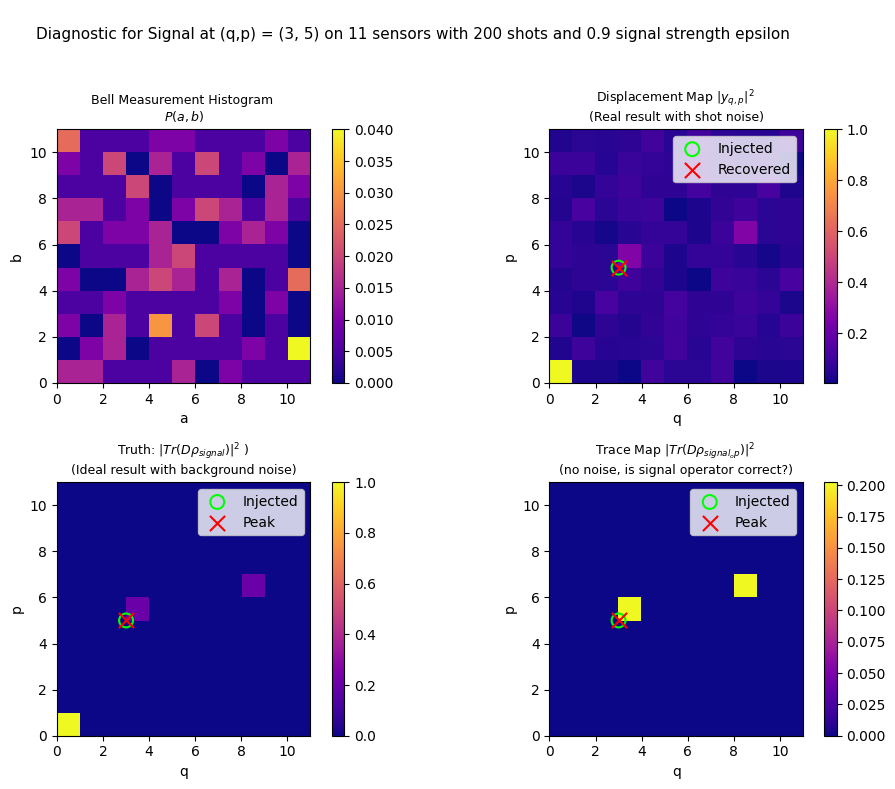

In [ ]:
# @title Diagnosis for Bell Protocol

# (Displacement map of Bell Measurement on Conjugate Pairs)
import numpy as np
import matplotlib.pyplot as plt

import random
#seed_value = 42
#random.seed(seed_value)

# Quantum sensor array for photon localization in phase space (creates states and displacement operators)
class QuantumSensorArray:
    def __init__(self, n_sensors, array_length=1.0):
        self.n_sensors = n_sensors
        self.L = array_length
        self.dim = n_sensors  # Hilbert space dimension

    # Constructs the Heisenberg-Weyl displacement operator D_{q,p} = τ^{qp} Z^p X^q
    def get_displacement_operator(self, q_idx, p_idx):
        d = self.dim
        omega = np.exp(2j * np.pi / d)
        Z = np.diag([omega ** j for j in range(d)])
        X = np.roll(np.eye(d), 1, axis=0)
        tau = np.exp(np.pi * 1j * (d + 1) / d)
        D_qp = tau ** (q_idx * p_idx) * np.linalg.matrix_power(Z, p_idx) @ np.linalg.matrix_power(X, q_idx)
        return D_qp

# Constructs Bell basis |Φ_{a,b}> which is eigenbasis for D_{q,p} ⊗ D_{-q,p}. |Φ_{a,b}> = (1/√d) Σ_j exp(2πi*b*j/d) |j+a> ⊗ |-j>
def construct_bell_basis(sensor_array):
    d = sensor_array.dim
    bell_states = []
    for a in range(d):
        for b in range(d):
            state = np.zeros(d * d, dtype=complex)
            for j in range(d):
                phase = np.exp(2j * np.pi * b * j / d)
                ket1_idx = (j + a) % d
                ket2_idx = (-j + d) % d  # Use +d to ensure positive result before modulo
                final_idx = ket1_idx * d + ket2_idx
                state[final_idx] += phase
            state /= np.sqrt(d) # Normalize
            bell_states.append(state)
    return np.array(bell_states).T

# Simulates measurements of rho_tensor in Bell basis with projectors (outer product): bell_state @ bell_state.conj().T
def simulate_bell_measurements(rho_tensor, d, sensor_array, n_shots=1000):
    bell_basis = construct_bell_basis(sensor_array)
    projectors = []
    for i in range(d * d):
        bell_state = bell_basis[:, i:i+1]
        projector = bell_state @ bell_state.conj().T
        projectors.append(projector)

    # Theoretical probabilities calculated inside simulate_bell_measurements according to Born rule: $p_{a,b} = \text{Tr}[\Pi_{a,b} (\rho \otimes \rho^*)]$
    probs = [np.real(np.trace(p @ rho_tensor)) for p in projectors]
    probs = np.maximum(0, probs)
    probs /= np.sum(probs)

    outcomes = np.random.choice(d * d, size=n_shots, p=probs)
    a_vals = outcomes // d
    b_vals = outcomes % d
    return a_vals, b_vals

# Fourier kernel (character) $e^{i \frac{2\pi}{d} (a p - b q)}$</font> = $\chi_{q,p}(a,b)$
# to reconstruct displacement map |y_{q,p}|^2 from Bell measurement outcomes p_{a,b}
# Estimator v_qp is for y_{q,p}^2. The map shows |v_qp| which is |y_{q,p}|^2
def compute_displacement_map(p_ab, d):
    v_qp = np.zeros((d, d), dtype=complex)
    a_coords = np.arange(d)
    b_coords = np.arange(d)

    for q in range(d):
        for p in range(d):
            phase_grid = np.exp(2j * np.pi * (a_coords[:, np.newaxis] * p - b_coords * q) / d)
            v_qp[q, p] = np.sum(p_ab * phase_grid)

    return np.abs(v_qp)

# Special: Computes 'ground truth' displacement map |y_{q,p}|^2 by directly calculating y_{q,p} = Tr(D_{q,p} ρ)
def compute_yqp_via_trace(rho, sensor_array):
    d = sensor_array.dim
    y_qp = np.zeros((d, d), dtype=complex)
    for q in range(d):
        for p in range(d):
            D = sensor_array.get_displacement_operator(q, p)
            y_qp[q, p] = np.trace(D @ rho)
    return np.abs(y_qp) ** 2

# Runs test for a given signal displacement (q_0, p_0).
def test_bell_on_pure_signal(sensor_array, q_0, p_0, epsilon=0.4, n_shots=1000):
    d = sensor_array.dim

    # Step 1: Construct unknown signal state ρ_signal: To create a signal peak at (q₀,p₀) in the displacement basis,
    # the state ρ = (1/d)(I + ε * signal_op) is constructed, where signal_op is Hermitian.
    D_qp_0 = sensor_array.get_displacement_operator(q_0, p_0)
    signal_operator = 0.5 * (D_qp_0.conj().T + D_qp_0)  # The signal is on the D† component of Bloch decomposition
    rho_signal = (1/d) * (np.eye(d) + epsilon * signal_operator)

    # The "pure signal" is the part of the state deviating from the identity.
    pure_signal_density = (epsilon / d) * signal_operator

    # Step 2: Construct the conjugate pair ρ ⊗ ρ* for measurement
    rho_tensor = np.kron(rho_signal, np.conjugate(rho_signal))

    # Step 3: Simulate Bell measurements on the prepared rho_tensor
    a_vals, b_vals = simulate_bell_measurements(rho_tensor, d, sensor_array, n_shots=n_shots)


    # Step 4: Create the Bell outcome histogram from the measurement samples
    p_ab, _, _ = np.histogram2d(a_vals, b_vals, bins=d, range=[[0, d], [0, d]])
    if np.sum(p_ab) > 0:
        p_ab /= np.sum(p_ab)

    # Step 5: Reconstruct the displacement map from the histogram
    displacement_map = compute_displacement_map(p_ab, d)
    q_star, p_star = np.unravel_index(np.argmax(displacement_map), displacement_map.shape)

    # Step 6: Compute ground truth maps for comparison
    trace_map = compute_yqp_via_trace(rho_signal, sensor_array)
    trace_map_signal = compute_yqp_via_trace(pure_signal_density, sensor_array)
    true_qp_from_trace = np.unravel_index(np.argmax(trace_map), trace_map.shape)
    signal_peak = np.unravel_index(np.argmax(trace_map_signal), trace_map_signal.shape)



    # SPECIAL: Find peaks while ignoring the (0,0) artifact
    # Make a copy to not alter the plot
    displacement_map_for_peak_finding = displacement_map.copy()
    trace_map_for_peak_finding = trace_map.copy()
    # Set the (0,0) element to 0 so it's not picked by argmax
    displacement_map_for_peak_finding[0, 0] = 0
    trace_map_for_peak_finding[0, 0] = 0
    # Find the argmax on the modified maps
    q_star, p_star = np.unravel_index(np.argmax(displacement_map_for_peak_finding), displacement_map.shape)
    true_qp_from_trace = np.unravel_index(np.argmax(trace_map_for_peak_finding), trace_map.shape)


    # Print Diagnostics
    print("="*70)
    print(f"DIAGNOSIS FOR INJECTED SIGNAL")
    print(f"for (q,p) = ({q_0}, {p_0}) on {d} sensors with {n_shots} shots and {epsilon} signal strength ε")
    print("="*70)
    print(f"Recovered peak from Bell measurement:  (q*, p*) = ({q_star}, {p_star})")
    print(f"Ground truth peak from Tr(D ρ_signal):   (q, p) = ({int(true_qp_from_trace[0])}, {int(true_qp_from_trace[1])})")
    print(f"Ground truth peak from Tr(D signal):     (q, p) = ({int(signal_peak[0])}, {int(signal_peak[1])})")
    print("-" * 70)

    # Analyze which peak is stronger in the displacement map
    q_neg = (-q_0) % d
    p_neg = (-p_0) % d
    peak1_height = displacement_map[q_0, p_0]
    peak2_height = displacement_map[q_neg, p_neg]
    print(f"Peaks at `(q_0, p_0)` and `(-q_0, -p_0) mod d` in displacement map:")
    print(f"  At injected (q₀,p₀)          = ({q_0},{p_0}): {peak1_height:.26f}")
    print(f"  At symmetric (-q₀,-p₀) mod d = ({q_neg},{p_neg}): {peak2_height:.26f}")
    print(f"Final decision: ({q_star}, {p_star})")
    # Decision based on which peak is higher after Fourier reconstruction,
    # which depends on accumulated shot noise across all measurements.
    print("-" * 70)


    ######## Diagnostic: Manually compute all p_{a,b} = ⟨Φ_{a,b}|ρ⊗ρ*|Φ_{a,b}⟩
    bell_basis = construct_bell_basis(sensor_array)
    bell_probs = []
    for idx in range(d * d):
        phi_ab = bell_basis[:, idx]
        prob = np.real(phi_ab.conj().T @ rho_tensor @ phi_ab)
        bell_probs.append((idx // d, idx % d, prob))  # (a, b, p_{a,b})

    # Sort by descending probability
    bell_probs.sort(key=lambda x: x[2], reverse=True)

    ####### rank probabilities
    #print("Top Bell measurement probabilities")
    #for rank, (a, b, prob) in enumerate(bell_probs[:5]):
    #    print(f"Rank {rank+1}: (a,b) = ({a},{b}), p = {prob:.6f}")
    #print("-" * 70)

    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'\nDiagnostic for Signal at (q,p) = ({q_0}, {p_0}) on {d} sensors with {n_shots} shots and {epsilon} signal strength epsilon', fontsize=11)

    im1 = ax1.imshow(p_ab.T, origin='lower', cmap='plasma', extent=[0,d,0,d])
    ax1.set_title("Bell Measurement Histogram \n$P(a,b)$", fontsize=9)
    ax1.set_xlabel("a")
    ax1.set_ylabel("b")
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(displacement_map.T, origin='lower', cmap='plasma', extent=[0,d,0,d])
    ax2.scatter(q_0, p_0, s=100, facecolors='none', edgecolors='lime', linewidths=1.5, label='Injected')
    ax2.scatter(q_star, p_star, color='red', s=120, marker='x', label='Recovered')
    ax2.set_title("Displacement Map $|y_{q,p}|^2$ \n(Real result with shot noise)", fontsize=9)
    ax2.set_xlabel("q")
    ax2.set_ylabel("p")
    ax2.legend()
    fig.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(trace_map.T, origin='lower', cmap='plasma', extent=[0,d,0,d])
    ax3.scatter(q_0, p_0, s=100, facecolors='none', edgecolors='lime', linewidths=1.5, label='Injected')
    ax3.scatter(true_qp_from_trace[0], true_qp_from_trace[1], color='red', s=120, marker='x', label='Peak')
    ax3.set_title("Truth: $|Tr(D \\rho_{signal})|^2$ ) \n(Ideal result with background noise)", fontsize=9)
    ax3.set_xlabel("q")
    ax3.set_ylabel("p")
    ax3.legend()
    fig.colorbar(im3, ax=ax3)

    im4 = ax4.imshow(trace_map_signal.T, origin='lower', cmap='plasma', extent=[0,d,0,d])
    ax4.scatter(q_0, p_0, s=100, facecolors='none', edgecolors='lime', linewidths=1.5, label='Injected')
    ax4.scatter(signal_peak[0], signal_peak[1], color='red', s=120, marker='x', label='Peak')
    ax4.set_title("Trace Map $|Tr(D \\rho_{signal_op})|^2$ \n(no noise, is signal operator correct?)", fontsize=9)
    ax4.set_xlabel("q")
    ax4.set_ylabel("p")
    ax4.legend()
    fig.colorbar(im4, ax=ax4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# EXECUTION
d = 11
sensor_array = QuantumSensorArray(n_sensors=d)
q_0 = 3
p_0 = 5
result = test_bell_on_pure_signal(sensor_array, q_0, p_0, epsilon=0.9, n_shots=200)

Starting quantum sensor array scaling experiment...
Testing system sizes: [3, 5, 7, 11, 13, 17, 19, 23]
Signal strength (epsilon): 0.9
Success criterion: 67% (⅔) correct localization over 10 trials)
Success = finding either (q0,p0) or (-q0,-p0) mod d
--------------------------------------------------


Testing different system sizes:   0%|          | 0/8 [00:00<?, ?it/s]

d=3: minimal shots = 70


Testing different system sizes:  25%|██▌       | 2/8 [00:00<00:00,  9.35it/s]

d=5: minimal shots = 80


Testing different system sizes:  38%|███▊      | 3/8 [00:00<00:01,  4.06it/s]

d=7: minimal shots = 90


Testing different system sizes:  50%|█████     | 4/8 [00:09<00:14,  3.60s/it]

d=11: minimal shots = 150


Testing different system sizes:  62%|██████▎   | 5/8 [00:34<00:32, 10.80s/it]

d=13: minimal shots = 125


Testing different system sizes:  75%|███████▌  | 6/8 [02:32<01:33, 46.51s/it]

d=17: minimal shots = 150


Testing different system sizes:  88%|████████▊ | 7/8 [07:14<02:02, 122.08s/it]

d=19: minimal shots = 175


Testing different system sizes: 100%|██████████| 8/8 [23:50<00:00, 178.87s/it]

d=23: minimal shots = 175


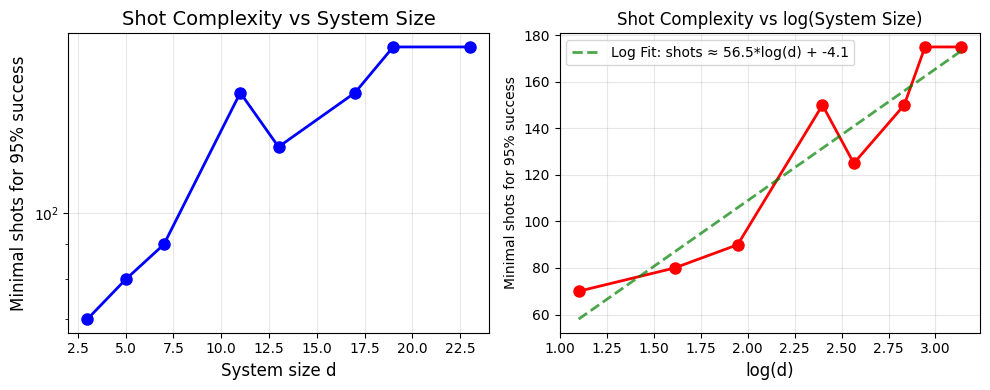


SCALING EXPERIMENT SUMMARY
d =  3:    70 shots | log(d) = 1.099
d =  5:    80 shots | log(d) = 1.609
d =  7:    90 shots | log(d) = 1.946
d = 11:   150 shots | log(d) = 2.398
d = 13:   125 shots | log(d) = 2.565
d = 17:   150 shots | log(d) = 2.833
d = 19:   175 shots | log(d) = 2.944
d = 23:   175 shots | log(d) = 3.135

System size increased by factor: 7.7
Required shots increased by factor: 2.5
Logarithmic fit: shots ≈ 56.5*log(d) + -4.1


In [ ]:
# @title 𝑑-Scaling Behavior of Conjugate Pairs (Magnitude Learning)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Quantum sensor array for photon localization in phase space
class QuantumSensorArray:
    def __init__(self, n_sensors, array_length=1.0):
        self.n_sensors = n_sensors
        self.L = array_length
        self.dim = n_sensors  # Hilbert space dimension

    # Constructs the Heisenberg-Weyl displacement operator D_{q,p} = τ^{qp} Z^p X^q
    def get_displacement_operator(self, q_idx, p_idx):
        d = self.dim
        omega = np.exp(2j * np.pi / d)
        Z = np.diag([omega ** j for j in range(d)])
        X = np.roll(np.eye(d), 1, axis=0)
        tau = np.exp(np.pi * 1j * (d + 1) / d)
        D_qp = tau ** (q_idx * p_idx) * np.linalg.matrix_power(Z, p_idx) @ np.linalg.matrix_power(X, q_idx)
        return D_qp

# Constructs Bell basis |Φ_{a,b}> (eigenbasis for D_{q,p} ⊗ D_{-q,p})
def construct_bell_basis(sensor_array):
    d = sensor_array.dim
    bell_states = []
    for a in range(d):
        for b in range(d):
            state = np.zeros(d * d, dtype=complex)
            for j in range(d):
                phase = np.exp(2j * np.pi * b * j / d)
                ket1_idx = (j + a) % d
                ket2_idx = (-j + d) % d
                final_idx = ket1_idx * d + ket2_idx
                state[final_idx] += phase
            state /= np.sqrt(d)
            bell_states.append(state)
    return np.array(bell_states).T

# Simulates measurements of rho_tensor in Bell basis
def simulate_bell_measurements(rho_tensor, d, sensor_array, n_shots=1000):
    bell_basis = construct_bell_basis(sensor_array)
    projectors = []
    for i in range(d * d):
        bell_state = bell_basis[:, i:i+1]
        projector = bell_state @ bell_state.conj().T
        projectors.append(projector)

    probs = [np.real(np.trace(p @ rho_tensor)) for p in projectors]
    probs = np.maximum(0, probs)
    probs /= np.sum(probs)

    outcomes = np.random.choice(d * d, size=n_shots, p=probs)
    a_vals = outcomes // d
    b_vals = outcomes % d
    return a_vals, b_vals

# Fourier reconstruction to get displacement map |y_{q,p}|^2
def compute_displacement_map(p_ab, d):
    v_qp = np.zeros((d, d), dtype=complex)
    a_coords = np.arange(d)
    b_coords = np.arange(d)

    for q in range(d):
        for p in range(d):
            phase_grid = np.exp(2j * np.pi * (a_coords[:, np.newaxis] * p - b_coords * q) / d)
            v_qp[q, p] = np.sum(p_ab * phase_grid)

    return np.abs(v_qp)

# Single trial: returns True if localization succeeds (finds either (q0,p0) or (-q0,-p0))
def run_single_trial(sensor_array, q_0, p_0, epsilon, n_shots):
    d = sensor_array.dim

    # Step 1: Construct signal state
    D_qp_0 = sensor_array.get_displacement_operator(q_0, p_0)
    signal_operator = 0.5 * (D_qp_0.conj().T + D_qp_0)
    rho_signal = (1/d) * (np.eye(d) + epsilon * signal_operator)

    # Step 2: Prepare tensor product for measurement
    rho_tensor = np.kron(rho_signal, np.conjugate(rho_signal))

    # Step 3: Simulate measurements
    a_vals, b_vals = simulate_bell_measurements(rho_tensor, d, sensor_array, n_shots=n_shots)

    # Step 4: Create histogram
    p_ab, _, _ = np.histogram2d(a_vals, b_vals, bins=d, range=[[0, d], [0, d]])
    if np.sum(p_ab) > 0:
        p_ab /= np.sum(p_ab)

    # Step 5: Reconstruct displacement map
    displacement_map = compute_displacement_map(p_ab, d)

    # Find peak while ignoring (0,0) artifact
    displacement_map_copy = displacement_map.copy()
    displacement_map_copy[0, 0] = 0
    q_star, p_star = np.unravel_index(np.argmax(displacement_map_copy), displacement_map.shape)

    # Check success: recovered peak matches either (q0,p0) or (-q0,-p0) mod d
    success = ((q_star == q_0 and p_star == p_0) or
               (q_star == (-q_0) % d and p_star == (-p_0) % d))

    return success

# Calculate success rate over multiple trials
def calculate_success_rate(sensor_array, q_0, p_0, epsilon, n_shots, n_trials=100):
    successes = 0
    for _ in range(n_trials):
        if run_single_trial(sensor_array, q_0, p_0, epsilon, n_shots):
            successes += 1
    return successes / n_trials

# Find minimal n_shots for given success threshold
def find_minimal_shots(sensor_array, q_0, p_0, epsilon, success_threshold=0.95,
                      n_shots_range=None, n_trials_per_test=100):
    if n_shots_range is None:
        n_shots_range = [200, 225, 250, 275, 300]

    for n_shots in n_shots_range:
        success_rate = calculate_success_rate(sensor_array, q_0, p_0, epsilon,
                                            n_shots, n_trials_per_test)
        if success_rate >= success_threshold:
            return n_shots

    return None  # Failed to find within range

# Main scaling experiment
def run_scaling_experiment(d_values, epsilon=0.9, success_threshold=0.95,
                          n_trials_per_test=10, n_shots_max=2000):
    results = {'d': [], 'minimal_shots': [], 'log_d': []}

    # Define shot number search range
    n_shots_range = list(range(10, 100, 10)) + list(range(100, 1000, 25)) + \
                   list(range(1000, n_shots_max + 1, 500))

    for d in tqdm(d_values, desc="Testing different system sizes"):
        sensor_array = QuantumSensorArray(n_sensors=d)

        # Choose test signal location (avoid edges and (0,0))
        q_0 = d // 3
        p_0 = d // 2

        minimal_shots = find_minimal_shots(sensor_array, q_0, p_0, epsilon,
                                         success_threshold, n_shots_range,
                                         n_trials_per_test)

        if minimal_shots is not None:
            results['d'].append(d)
            results['minimal_shots'].append(minimal_shots)
            results['log_d'].append(np.log(d))
            print(f"d={d}: minimal shots = {minimal_shots}")
        else:
            print(f"d={d}: FAILED to achieve {success_threshold:.0%} success rate")

    return results

# Plotting function
def plot_scaling_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot 1: minimal_shots vs d
    ax1.plot(results['d'], results['minimal_shots'], 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('System size d', fontsize=12)
    ax1.set_ylabel('Minimal shots for 95% success', fontsize=12)
    ax1.set_title('Shot Complexity vs System Size', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # Plot 2: minimal_shots vs log(d)
    ax2.plot(results['log_d'], results['minimal_shots'], 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('log(d)', fontsize=12)
    ax2.set_ylabel('Minimal shots for 95% success', fontsize=10)
    ax2.set_title('Shot Complexity vs log(System Size)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Add logarithmic scaling line for reference
    if len(results['log_d']) > 1:
        # Fit a linear model: shots = A * log(d) + B
        A, B = np.polyfit(results['log_d'], results['minimal_shots'], 1)
        fitted_line = A * np.array(results['log_d']) + B
        ax2.plot(results['log_d'], fitted_line, 'g--', linewidth=2, alpha=0.7,
                label=f'Log Fit: shots ≈ {A:.1f}*log(d) + {B:.1f}')
        ax2.legend()

    plt.tight_layout()
    plt.savefig('quantum_sensor_scaling.png', dpi=150)
    plt.show()

    # Print summary statistics
    print("\n" + "="*50)
    print("SCALING EXPERIMENT SUMMARY")
    print("="*50)
    for i in range(len(results['d'])):
        print(f"d = {results['d'][i]:2d}: {results['minimal_shots'][i]:5d} shots | log(d) = {results['log_d'][i]:.3f}")

    if len(results['d']) > 1:
        # Calculate growth rate
        d_growth = results['d'][-1] / results['d'][0]
        shots_growth = results['minimal_shots'][-1] / results['minimal_shots'][0]
        print(f"\nSystem size increased by factor: {d_growth:.1f}")
        print(f"Required shots increased by factor: {shots_growth:.1f}")

        # Show logarithmic fit (theory prediction: O(log d))
        A, B = np.polyfit(results['log_d'], results['minimal_shots'], 1)
        print(f"Logarithmic fit: shots ≈ {A:.1f}*log(d) + {B:.1f}")

# MAIN EXECUTION - Scaling - small
if __name__ == "__main__":
    # Test with prime numbers as suggested
    d_values = [3, 5, 7, 11, 13, 17, 19, 23]

    print("Starting quantum sensor array scaling experiment...")
    print(f"Testing system sizes: {d_values}")
    print(f"Signal strength (epsilon): 0.9")
    print(f"Success criterion: 67% (⅔) correct localization over 10 trials)")
    print(f"Success = finding either (q0,p0) or (-q0,-p0) mod d")
    print("-" * 50)

    # Run the experiment
    results = run_scaling_experiment(d_values, epsilon=0.9, success_threshold=0.66667,
                                   n_trials_per_test=10, n_shots_max=600)

    # Plot and analyze results
    if results['d']:
        plot_scaling_results(results)
    else:
        print("No successful results to plot")

<font color="blue">**Technical Summary of Conjugate Pairs Paper**

In the paper they compute: <font color="orange">$y_{q,p}^2$</font> $\approx \sum_{a,b} $ <font color="red">$p_{a,b}$</font> <font color="blue">$e^{i \frac{2\pi}{d} (a p - b q)}$</font> (from Fourier-like inversion over Bell measurement statistics)

* <font color="orange">$y_{q,p}^2$</font>: displacement coefficient measuring how aligned the signal is with a displacement operator $D_{q,p}$ (conceptually close to Wigner function $W_\rho(q,p)$). Encodes position and momentum of signal -> this we want to estimate

* <font color="red">$p_{a,b}$</font> = $\text{Tr}[\Pi_{a,b} (\rho \otimes \rho^*)]$ probability of obtaining outcome $(a,b)$ when measuring the joint state $\rho \otimes \rho^*$ in the Bell basis (projecting onto the entangled state $|\Phi_{a,b}\rangle$)

  * $\Pi_{a,b} = |\Phi_{a,b}\rangle \langle \Phi_{a,b}|$ are Bell projectors, projecting onto entangled basis states. For example $\Pi_{0,0} = |\Phi_{0,0}\rangle \langle \Phi_{0,0}|$. And for qubits d=2 Bell basis has 4 Bell states (a,b) $\in$ (0,0), (0,1), (1,0), (1,1).

    * Each Bell state $|\Phi_{a,b}\rangle$ is an **eigenstates** of the observable 'displacement operator' $D_{q,p} \otimes D_{-q,p}$
    * Eigenvalues are **Fourier characters** $\chi_{q,p}(a,b)$ of operator spectrum obtained when measuring in Bell basis - $(a,b)$ live in dual space to position momentum space $(q,p)$ - like what time would be to frequency in Fourier - **We measure in Bell basis because it gives access to the spectrum (Fourier components) of hidden displacement operator!**
    * Measurement probabilities $p_{a,b}$ encode expectation values of dual values (a,b) ($p_{a,b}$ form **characteristic function**) - With entangled Bell measurements we measure probability of $(a,b)$ because they encode the characteristic function $\chi_{q,p}(a,b)$.
    * Applying Fourier inversion $\chi_{q,p}(a,b) = e^{i\frac{2\pi}{d}(a p - b q)}$ recovers $y_{q,p}^2$ in measurement domain to estimate displacements $(q,p)$

  * $\rho \otimes \rho^*$: conjugate pair allows access to structured correlation and commuting extensions. We use the complex conjugate to ensure that the Bell measurements access bilinear correlations between $\rho$ and $\rho^*$, which encode the squared modulus of the Fourier component — i.e., $y_{q,p}^2$.
  
    * $\rho_{q,p,r} = \frac{1}{d} \left( I + r \cdot \varepsilon \cdot E_{q,p} \right)$ is quantum state with random background and small structured deviation injected where $E_{q,p} = D_{q,p} \sigma D_{q,p}^\dagger$. From this, we construct the conjugate pair as the tensor product $\rho_{q,p,r} \otimes \rho_{q,p,r}^*$

  
* <font color="blue">$e^{i \frac{2\pi}{d} (a p - b q)}$</font> = $\chi_{q,p}(a,b)$ is the character (Fourier phase factor or fourier transform kernel) to turn our characteristic function details back into a Wigner-like $y_{q,p}^2$ position and momentum information.